In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/var/folders/zt/tzrd5yhd39x_x40bnnfv9wtnzbbz1m/T/ipykernel_47070/3777615979.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


# Определение возраста покупателей

Исследование для супермаркета «Хлеб-Соль». Супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы,
- контролировать добросовестность кассиров при продаже алкоголя.

Нужно построить модель, которая по фотографии определит приблизительный возраст человека. В распоряжении исследователя набор фотографий людей с указанием возраста. Значение метрики MAE должно быть меньше 8.

In [1]:
# загружаю все нужные для проекта библиотеки

import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications.resnet import ResNet50

In [2]:
def load_train(path): # загрузка и аугментация тренировочной выборки
    train_datagen = ImageDataGenerator(rotation_range=90,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       brightness_range=[0.8,1.2],
                                       channel_shift_range=0.2,
                                       validation_split=0.25,
                                       rescale=1./255,
                                       horizontal_flip=True,
                                       vertical_flip=True)
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + 'labels.csv'),
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        seed=12345)
    return train_datagen_flow

def load_test(path): # загрузка валидационной выборки
    valid_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)

    valid_datagen_flow = valid_datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + 'labels.csv'),
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        seed=12345)

    return valid_datagen_flow

def create_model(input_shape=(150, 150, 3)): # создание модели
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mean_squared_error', optimizer=RMSprop(lr=0.0001), metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=7,
                steps_per_epoch=None, validation_steps=None): # тренировка модели и вывод метрики качества
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

## Исследовательский анализ

In [3]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
    dataframe=labels,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    seed=12345)

Found 7591 validated image filenames.


Всего нашлось 7591 изображения.

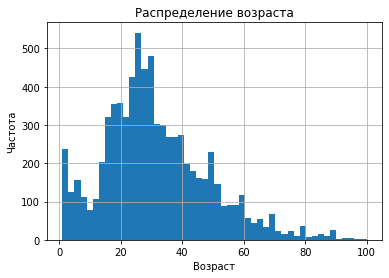

In [4]:
labels['real_age'].hist(bins=50)
plt.title('Распределение возраста')
plt.xlabel('Возраст')
plt.ylabel('Частота')
plt.show()

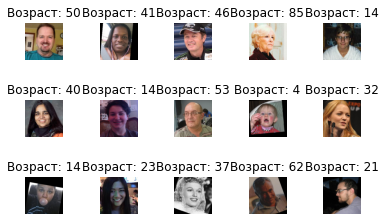

In [5]:
images, labels = next(train_gen_flow)
plt.figure(figsize=(15,10))
for i in range(15):
    plt.subplot(3, 5, i+1)
    plt.imshow(images[i])
    plt.title('Возраст: ' + str(labels[i]))
    plt.axis('off')
plt.subplots_adjust(wspace=1)
plt.show()

В основном в датасете фотографии людей от 18 до 50. Возможно, модель не научится хорошо распознавать детей, а нам это важно по бизнес-цели: проверять, насколько чисто продают алкоголь продавцы. Фотографии ещё не приведены к одному виду: в датасете есть как чёрно-белые, так и цветные фотографии. Нужно будет их привести к одной яркости. 

## Вывод модели

Train for 475 steps, validate for 475 steps
Epoch 1/7
2024-05-04 09:26:45.741883: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-05-04 09:26:46.052372: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
475/475 - 178s - loss: 202.5057 - mae: 10.9105 - val_loss: 319.8828 - val_mae: 13.2838
Epoch 2/7
475/475 - 172s - loss: 156.6130 - mae: 9.5899 - val_loss: 168.5411 - val_mae: 9.7197
Epoch 3/7
475/475 - 178s - loss: 139.3289 - mae: 9.0122 - val_loss: 163.0344 - val_mae: 9.4537
Epoch 4/7
475/475 - 177s - loss: 128.4459 - mae: 8.6174 - val_loss: 133.6394 - val_mae: 8.8737
Epoch 5/7
475/475 - 177s - loss: 118.0891 - mae: 8.2586 - val_loss: 152.8046 - val_mae: 9.3838
Epoch 6/7
475/475 - 185s - loss: 113.0183 - mae: 8.0786 - val_loss: 126.1858 - val_mae: 8.3866
Epoch 7/7
475/475 - 186s - loss: 106.6842 - mae: 7.8743 - val_loss: 95.5646 - val_mae: 7.3138
WARNING:tensorflow:sample_weight modes were coerced from
...
to
['...']
475/475 - 42s - loss: 95.5646 - mae: 7.3138
Test MAE: 7.3138

## Вывод 

Значение метрики MAE - 7. Использовала подготовленные веса, добавила слой dense с 1024 нейронами и слой dropout, чтобы предотвратить переобучение. Использовала также RMSprop вместо Adam.